<h3 style='color:#FF6363'>Importing required libraries</h3>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

<h3 style='color:#FF6363'>Creating Static variable</h3>

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

<h3 style='color:#FF6363'>Downloading dataset tfdataset</h3>

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


<h3 style='color:#FF6363'>Getting class_names</h3>

In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

<h3 style='color:#FF6363'>Some image visualizations</h3>

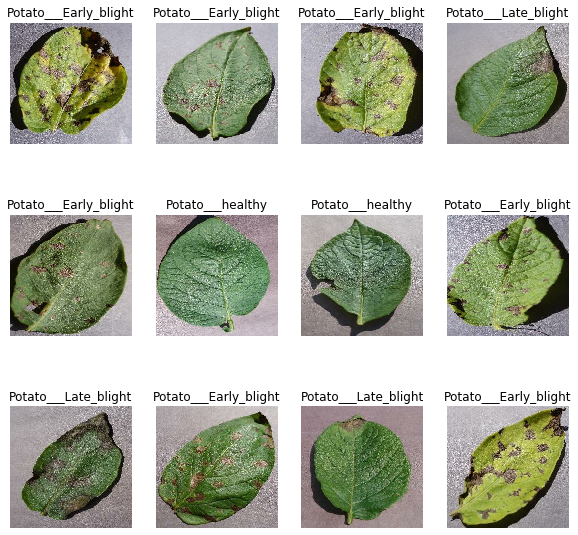

In [5]:
plt.figure(figsize = (10, 10))
for image_batch, label_batch in dataset.take(1):
#     print(image_batch.shape)
#     print(label_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

<h3 style='color:#FF6363'>Splitting dataset into training testing and splitting accoring to below %</h3>

80% ==> Training
20% ==> Test
    10% ==> Validation
    10% ==> Testing

In [6]:
train_size = 0.8
train_test_size = int(len(dataset)*train_size)

In [7]:
train_ds = dataset.take(train_test_size)
len(train_ds)

54

In [8]:
test_ds = dataset.skip(train_test_size)
len(test_ds)

14

In [9]:
val_size = 0.1
validation_size = int(len(dataset)*val_size)

In [10]:
val_ds = test_ds.take(validation_size)
len(val_ds)

6

In [11]:
test_ds = test_ds.skip(validation_size)
len(test_ds)

8

<h3 style='color:#FF6363'>All above operations in single functions</h3>

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+val_split+test_split) == 1
    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

<h3 style='color:#FF6363'>Verifying the lengths of train test and validation datasets</h3>

In [14]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


<h3 style='color:#FF6363'>Saving dataset in catch, shuffling the dataset and prefeching</h3>

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<h3 style='color:#FF6363'>Printing single image in numpy and checking it's dimensions</h3>

In [16]:
for image_batch, label_batch in dataset.take(1):
#     print(image_batch[0].numpy().shape) # 256*256*3 where 3 is RGB channel
    print(image_batch[0].numpy()/255)

[[[0.7294118  0.7372549  0.78431374]
  [0.7019608  0.70980394 0.75686276]
  [0.72156864 0.7294118  0.7764706 ]
  ...
  [0.59607846 0.60784316 0.68235296]
  [0.6156863  0.627451   0.7019608 ]
  [0.61960787 0.6313726  0.7058824 ]]

 [[0.70980394 0.7176471  0.7647059 ]
  [0.7411765  0.7490196  0.79607844]
  [0.7254902  0.73333335 0.78039217]
  ...
  [0.5803922  0.5921569  0.6666667 ]
  [0.59607846 0.60784316 0.68235296]
  [0.6        0.6117647  0.6862745 ]]

 [[0.7176471  0.7254902  0.77254903]
  [0.77254903 0.78039217 0.827451  ]
  [0.7372549  0.74509805 0.7921569 ]
  ...
  [0.5803922  0.5921569  0.6666667 ]
  [0.59607846 0.60784316 0.68235296]
  [0.6039216  0.6156863  0.6901961 ]]

 ...

 [[0.40392157 0.39607844 0.4509804 ]
  [0.46666667 0.45882353 0.5137255 ]
  [0.4862745  0.47843137 0.53333336]
  ...
  [0.58431375 0.57254905 0.64705884]
  [0.43137255 0.41960785 0.49411765]
  [0.42352942 0.4117647  0.4862745 ]]

 [[0.5176471  0.50980395 0.5647059 ]
  [0.48235294 0.4745098  0.5294118 ]


<h3 style='color:#FF6363'>Data preprocessing --> data resizing and data rescaling</h3>

In [17]:
resize_and_rescale = tf.keras.Sequential([
    # first it will resize the image     
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),

    # second it will rescale the image inbetween 0 and 1
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

<h3 style='color:#FF6363'>Applying some data augmentation techniques</h3>

In [18]:
data_augmentation = tf.keras.Sequential([
    # first it will randomly flip the image    
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),

    # second it will randomly rotate the image
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape = input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS
)

Epoch 1/50
54/54 [==============================] - 67s 1s/step - loss: 0.8895 - accuracy: 0.5237 - val_loss: 0.8440 - val_accuracy: 0.6771
Epoch 2/50
54/54 [==============================] - 62s 1s/step - loss: 0.6302 - accuracy: 0.7193 - val_loss: 0.8059 - val_accuracy: 0.6667
Epoch 3/50
54/54 [==============================] - 79s 1s/step - loss: 0.3893 - accuracy: 0.8270 - val_loss: 0.3226 - val_accuracy: 0.8229
Epoch 4/50
54/54 [==============================] - 92s 2s/step - loss: 0.2881 - accuracy: 0.8785 - val_loss: 0.2198 - val_accuracy: 0.9010
Epoch 5/50
54/54 [==============================] - 92s 2s/step - loss: 0.2488 - accuracy: 0.8976 - val_loss: 0.2241 - val_accuracy: 0.9115
Epoch 6/50
54/54 [==============================] - 92s 2s/step - loss: 0.2010 - accuracy: 0.9207 - val_loss: 0.2053 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 88s 2s/step - loss: 0.2261 - accuracy: 0.9074 - val_loss: 0.1683 - val_accuracy: 0.9323
Epoch 8/50
54/54 [==

In [23]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 4s 227ms/step - loss: 0.0556 - accuracy: 0.9883


[0.055630240589380264, 0.98828125]

In [24]:
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 50, 'steps': 54}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [25]:
history.history['accuracy']

[0.5237268805503845,
 0.7193287014961243,
 0.8269675970077515,
 0.8784722089767456,
 0.8975694179534912,
 0.9207175970077515,
 0.9074074029922485,
 0.9403935074806213,
 0.9438657164573669,
 0.9380787014961243,
 0.9502314925193787,
 0.9537037014961243,
 0.9502314925193787,
 0.9473379850387573,
 0.9560185074806213,
 0.9681712985038757,
 0.9664351940155029,
 0.9641203880310059,
 0.9733796119689941,
 0.9537037014961243,
 0.9635416865348816,
 0.9791666865348816,
 0.9762731194496155,
 0.9704861044883728,
 0.9832175970077515,
 0.9762731194496155,
 0.9739583134651184,
 0.9797453880310059,
 0.9728009104728699,
 0.9699074029922485,
 0.9745370149612427,
 0.9774305820465088,
 0.9797453880310059,
 0.9884259104728699,
 0.9866898059844971,
 0.9820601940155029,
 0.9797453880310059,
 0.9774305820465088,
 0.9664351940155029,
 0.9762731194496155,
 0.9872685074806213,
 0.9884259104728699,
 0.9861111044883728,
 0.9826388955116272,
 0.9872685074806213,
 0.9930555820465088,
 0.9895833134651184,
 0.9820601940

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

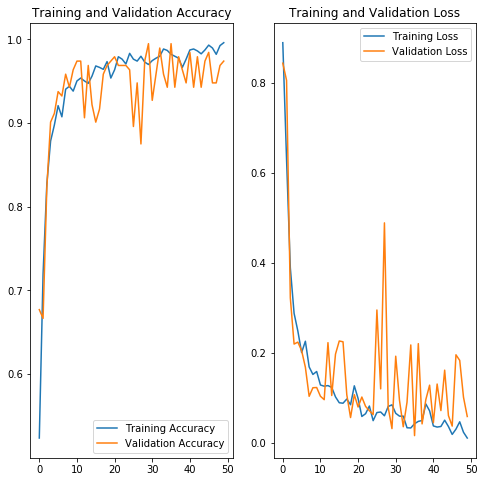

In [27]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
Actual Label: Potato___Late_blight
1/1 [==============================] - 0s 332ms/step
Predicted Label Potato___Late_blight


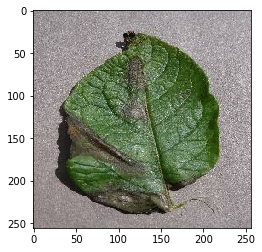

In [28]:
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:", class_names[labels_batch[0].numpy()])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label",class_names[np.argmax(batch_prediction[0])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0], 2)))
    
    return predicted_class, confidence

1/1 [==============================] - 0s 83ms/step


AxisError: axis 2 is out of bounds for array of dimension 1

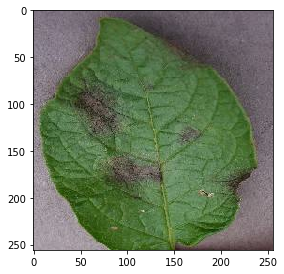

In [30]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[label[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")

In [32]:
import os
model_version = max([int(i) for i in (os.listdir("../models")+[0])]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
